# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
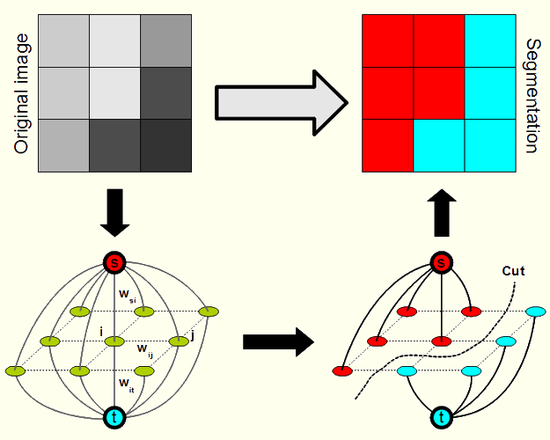

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
# import networkx as nx
import igraph as ig

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [61]:
def run(filename: str, grab_iters = 2, grab_comp=5, grab_gamma = 50, grab_conn=8, thresh=30000):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255],
    'BLACK' : [0,0,0],
    }#
    
    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}
    DRAW_SURE_BG = {'color' : COLORS['BLACK'], 'val' : 50}
    DRAW_SURE_FG = {'color' : COLORS['WHITE'], 'val' : 250}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,  # flag for drawing strokes
        'DRAW_RECT' : False,   # flag for drawing rectangle
        'rect_over' : False,   # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,   # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,     # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown
    save_mask = False
    
    #to store the images at each intermediate step
    iter_images = []
    output_images = []
    
    # Input and segmentation windows
    cv2.namedWindow('Input Image')#, cv2.WINDOW_GUI_NORMAL
    cv2.namedWindow('Segmented Image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        # cv2.imshow("MASK", mask)
        FLAGS = EventObj.flags
        cv2.imshow('Segmented Image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            print("Grab closing")
            break
        
        elif k == ord('0'): 
            # Strokes for background - and respectively in the mask the value for sure_bg would be = 100
            FLAGS['value'] = DRAW_SURE_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_SURE_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            '''
            mask should be the area that corresponds to the foreground image
            use img2 for this since it's the clear undrawn image now. 
            '''
            print("Implementing Grab Cut ...")
            print("Bounding Box around:" , FLAGS["RECT"])
            print("Image shape: ", img2.shape, "\n")
            # cv2.imshow('MASK', mask)
            # This mask is the black and white version of Image...
            gc = grab_cut(img2, mask, FLAGS["RECT"], DRAW_BG, DRAW_FG, DRAW_SURE_BG, DRAW_SURE_FG)
            final_mask, ims = gc.perform_grab_cut(iters = grab_iters, components = grab_comp, gamma=grab_gamma, connectivity = grab_conn, THRESH=thresh)
            
            iter_images.append(ims)
            print("Segmentation Done!!!\n")
            mask2 = np.where((final_mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            output_images.append(output)
            # save_mask = True
            
        # Updating the FLAG of EventObject
        EventObj.flags = FLAGS
        
        if save_mask:
            cv2.imwrite(filename+"_mask.png", mask2)
            save_mask = False
    
    return img, iter_images, output_images

In [4]:
def plot_seg_results(main_im, iter_images, output_images):
    
    print("Output images:",len(output_images), "\nImages per run", len(iter_images[0]))
    
    if not (len(output_images)==1 and len(iter_images[0])==1):
        
        for i in range(len(output_images)):
            
            fig, ax = plt.subplots(1,len(iter_images[i]), figsize=(15,8))
            
            for j, im in enumerate(iter_images[i]):
                ax[j].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                ax[j].set_title("Out:"+str(i)+" Iter image: "+str(j))
    
        print()
        print()
        
    if len(output_images) > 0 :
        fig2, ax2 = plt.subplots(1, len(output_images)+1, figsize=(15,8))

        ax2[0].imshow(cv2.cvtColor(main_im, cv2.COLOR_BGR2RGB))
        for i, o in enumerate(output_images):

            ax2[i+1].imshow(cv2.cvtColor(o, cv2.COLOR_BGR2RGB))
            ax2[i+1].set_title("Out Image:"+str(i))
    else:
        print("Error!")

__Metrics To Know How Well the Grab-Cut Segementation has happened.__

In [6]:
# Metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def acc(mask_true, mask_pred):
    return accuracy_score(mask_true.flatten(), mask_pred.flatten())
def jac(mask_true, mask_pred):
    return jaccard_score(mask_true.flatten(), mask_pred.flatten())
def dice(mask_true, mask_pred):
    y_true_f = mask_true.flatten()
    y_pred_f = mask_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) 
def scores(mask_true, mask_pred):
    print(f"Acc = {acc(mask_true, mask_pred)}, Jacc = {jac(mask_true, mask_pred)}, Dice = {dice(mask_true, mask_pred)}")

__Compute Scores:__
[Link](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)

In [7]:
def gray(img): return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [8]:
mask_true = gray(cv2.imread("../ground_truth/teddy.bmp"))/255
mask_pred = gray(cv2.imread("../images/teddy.jpg_mask.png"))/255
scores(mask_true, mask_pred)

Acc = 0.993391252034822, Jacc = 0.969116917479742, Dice = 0.9843162779308483


# Understanding GMM for Grabcut

The GMM or gaussian mixture model is an *unsupervised* algorithm that is used to cluster data points. The base assumption with GMM is that the different clusters (or subpopulations/components) that exist in the data have a **normal distribution**, ie. they are parameterized by a mean $\mu$ and a variance $\sigma$. 

A GMM learns the distribution of data points by trying to identify *k components* or *k* gaussian distributions for the given data. In order to estimate the parameters $\mu$ and $\sigma$ for the *k* components that our data points have, an expectation maximization approach is used. Mathematically, given $n$ points, each being $d$ dimension, the GMM estimates the parameters of the *k* gaussians by trying to maximze the probability of occurence of each of our data points. That is we wish to maximize (as log probability):

$$P(X|\pi, \mu ,\sigma) = \prod_{i=1}^{N} \sum_{k=1}^{K} (\pi_{k} . N(x_i | \mu_{k}, \sigma_{k}))$$
$$L = log(P(X|\pi, \mu ,\sigma)) = \sum_{i=1}^{N} log(\sum_{k=1}^{K} (\pi_{k} . N(x_i | \mu_{k}, \sigma_{k})))$$

This EM problem is an iterative procedure, where we start by initializing the normal dist parameters, then we compute the components for each data point (clusters to which the belong) and then recompute the vector of parameters ($\mu$, $\sigma$, $\pi$). The advantage with GMM over K-means clustering is that it is a soft clustering algorithm whereas kmeans is a hard clustering algorithm wherein a given sample is assigned to one and only one class. 

In **segmentation by Grabcut**, the entire image is represented as a gaussian mixture model. The GMM serves better as compared to a monochrome image model since constructing colour space histograms for all the colours in the image is impractical. There are ***two GMM models*** created in grabcut - 1) for the foreground pixel distribution and 2) for the background pixel distribution.The pixels belonging to the foreground and background are then assigned to one of the components from the bg or fg pixels respectively.

# Working of Grabcut

Grabcut is an iterative algorithm that works by constructing a graph from the image pixels and the GMMs of the background and foreground pixels. To start, the user marks a box containing the foreground pixels. This boxed region can also contain background pixels. Hence the entire image is divided into 3 parts - a) sure background, b) probable foreground, c) sure foreground. At the start of the iterations, the sure background pixels are {$\phi$}. The segmentation of the graph of pixels is done based on the **mincut** algorithm that aims at minimizing the cost of cutting edges in the graph of pixels that disconnects the foreground from the background. 

The cost (or energy) function for the mincut algorithm is defined over the edges of the graph. These edges account for two costs : 1) Unary cost **(U)** and 2) Binary or interpixel costs **(V)**. Mathematically this is represented as the *Gibbs Energy* for segmentation : 

$$E (\alpha, k, \theta, z) = U(\alpha, k, \theta, z) + V(\alpha, z)$$


### Step 1 : 
In the first step of Grabcut, the GMMs for the foreground and background pixels are initialised. Based on these models that are learnt, the **unary costs** for these pixels are assigned. While assigning the unary cost for the *fg pixels* the *bg GMM model* is used and vice versa for the *bg pixels*. This is because, the unary costs are assigned based on the **negative** of the *log likelihood*. Two terminal nodes, one for **fg terminal** and one for the **bg terminal** are added to the graph, and the unary costs are the capacities of the pixel-terminal edges to each of these terminals. A higher cost of an edge from a pixel to the fg terminal indicates that it's more likely to be an fg pixel. Unary costs are assigned as $U(\alpha, \mathbf{k}, \theta, \mathbf{z}) = \sum_{n}D(\alpha_n, k_n, \theta, z_n)$, where $D(\alpha_n, k_n, \theta, z_n) = -\log p(z_n | \alpha_n, k_n, \theta) - \log \pi(\alpha_n, k_n)$, and $p(.)$ is a Gaussian probability distribution, and $\pi(.)$ are mixture weighting coefficients, so that (up to a constant):

$$D(\alpha_n, k_n, \theta, z_n) = -\log \pi(\alpha_n, k_n) + \frac{1}{2} \log \det \Sigma (\alpha_n, k_n) + \frac{1}{2}[z_n - \mu(\alpha_n, k_n)]^{T}\Sigma(\alpha_n, k_n)^{-1}[z_n - \mu(\alpha_n, k_n)] = -\log \pi(\alpha_n, k_n) + -\log \left(\dfrac{1}{\sqrt{\left|\Sigma (\alpha_n, k_n)\right|}} e^{\left(-\dfrac{[z_n - \mu(\alpha_n, k_n)]^T\Sigma(\alpha_n, k_n)^{-1}[z_n - \mu(\alpha_n, k_n)]}{2}\right)}\right)$$


In [9]:
class GMM:
    
    def __init__(self, img, bg_ind, fg_ind, sure_bg_ind, sure_fg_ind):#
        
        self.img = np.asarray(img, dtype=np.float64)
        # np.where((self.mask == self.DRAW_BG['val']) | (self.mask == self.DRAW_SURE_BG['val']))
        # Within rectangle or box there may lie bg_ind as well as fg_ind
        self.bg_ind = bg_ind
        self.fg_ind = fg_ind
        # Out of the box there lies sure_bg_ind --> but for naming convention we put user stroke for sure_bg or sure_fg,
        # but when user give some strokes. SOme part within box becomes sure_bg and sure_fg
        self.sure_bg_ind = sure_bg_ind
        self.sure_fg_ind = sure_fg_ind
        # Store the Unary Costs in Dictionary Format (for foreground = source pixls as well as bg = sink pixels)
        self.fg_unary_cost = np.empty(img.shape[:2])
        self.bg_unary_cost = np.empty(img.shape[:2])
    
    '''
    Function to instantiate the GMM model for the proabable background and foreground
    '''
    def init_gmm(self, components=5):
        
        #fitting the background and probable foreground pixels to a GMM model
        self.bg_gmm = GaussianMixture(n_components = components, covariance_type='full', n_init = 1).fit(self.img[self.bg_ind])
        self.fg_gmm = GaussianMixture(n_components = components, covariance_type='full', n_init = 1).fit(self.img[self.fg_ind])
    
    
    def assign_unary_cost(self, fg_gmm_model, bg_gmm_model):
        '''
        Function to compute the unary costs for each pixel of it being connected to either the bg or the foreground.
        Assigning a D value to each pixel based on the GMM model
        '''
        # predictions = k_n = 1, ..., K (i.e., to assign in which gaussian of GMM for fg, that pixel lies.)
        # Why fg? Because that's the place where we are unsure about whether it lies in fg or bg. The rest is sureshot bg.
        # That's why we take all pixels in T_u = fg as of now = complement(sure bg), and pass it through gmm_model
        # which can be one of GMM_fg or GMM_bg.
        # -------------------------------------- For FG ------------------------------------------------------------
        predictions_fg = fg_gmm_model.predict(self.img[self.fg_ind])
        # -log(pi)
        neg_log_pi_fg = -np.log(fg_gmm_model.weights_)
        # Pre-compute the (log of determinant) and INverse  of Covariance matrix as this would be called multiple times 
        log_sigma_det_fg = [0.5*np.log(np.linalg.det(fg_gmm_model.covariances_[cov])) for cov in range(len(neg_log_pi_fg))]
        sigma_inv_fg = [np.linalg.inv(fg_gmm_model.covariances_[cov]) for cov in range(len(neg_log_pi_fg))]
        # mu of Gaussian models in Mixtures
        mu_fg = fg_gmm_model.means_
        # -------------------------------------- For BG ------------------------------------------------------------
        predictions_bg = bg_gmm_model.predict(self.img[self.fg_ind])
        # -log(pi)
        neg_log_pi_bg = -np.log(bg_gmm_model.weights_)
        # Pre-compute the (log of determinant) and INverse  of Covariance matrix as this would be called multiple times 
        log_sigma_det_bg = [0.5*np.log(np.linalg.det(bg_gmm_model.covariances_[cov])) for cov in range(len(neg_log_pi_bg))]
        sigma_inv_bg = [np.linalg.inv(bg_gmm_model.covariances_[cov]) for cov in range(len(neg_log_pi_bg))]
        # mu of Gaussian models in Mixtures
        mu_bg = bg_gmm_model.means_
        # -------------------------------------- Compute D ------------------------------------------------------------
        for i, (pred_fg, pred_bg) in enumerate(zip(predictions_fg, predictions_bg)):
            x,y = self.fg_ind[0][i], self.fg_ind[1][i]
            # Compute Unary Cost: See Below Markdown Cell for the formula
            D_fg = neg_log_pi_fg[pred_fg] + log_sigma_det_fg[pred_fg] + 0.5*((self.img[x,y,:]-mu_fg[pred_fg]).T @ (sigma_inv_fg[pred_fg]) @ (self.img[x,y,:]-mu_fg[pred_fg]))
            D_bg = neg_log_pi_bg[pred_bg] + log_sigma_det_bg[pred_bg] + 0.5*((self.img[x,y,:]-mu_bg[pred_bg]).T @ (sigma_inv_bg[pred_bg]) @ (self.img[x,y,:]-mu_bg[pred_bg]))
            # Update the weights
            self.fg_unary_cost[x, y] = D_bg# Weight reversal happens ---> due to negative-log-likelihood
            self.bg_unary_cost[x, y] = D_fg
        
        # Update the rest weights...
        # Out of the Box Part
        self.bg_unary_cost[self.bg_ind] = 1e12
        self.fg_unary_cost[self.bg_ind] = 0
        # IN bg_unary what are the potential for sure_bg and sure_fg
        self.bg_unary_cost[self.sure_bg_ind] = 1e12
        self.bg_unary_cost[self.sure_fg_ind] = 0
        # Same for fg_unary
        self.fg_unary_cost[self.sure_bg_ind] = 0
        self.fg_unary_cost[self.sure_fg_ind] = 1e12
        # NOte that self.sure_fg_ind is subset of self.fg_ind (proof in perform_grab_cut() function).
        # And since this information (i.e., sure_bg or sure_fg) is provided by user, we manually override the
        # potential value if there is any (assigned during D computation.)

### Step 2 :

In order to assign the binary costs, a neighbourhood of 8 connectivity or 4 connectivity is chosen where edges are added. The binary costs ensure that the neighbourhood and spatial effect is also factored in. The costs are assigned as :

$$V(\alpha, z) = \gamma \sum_{(m,n \in C)} \delta(\alpha_m, \alpha_n) exp(-\beta || z_m - z_n ||^{2})$$

The $\beta$ term relaxes the tendency to smoothness in regions of high contrast, ie: the edges are preserved. The $\gamma$ term is used to determine the degree of smoothness throughout the image. $\delta(\alpha_m, \alpha_n) = \begin{cases}1,\ \text{if}\ \alpha_m\neq\alpha_n\\0,\ \text{o/w}\end{cases}$

### Step 3 : 

Once the graph is prepared, the **mincut** algorithm is run on the graph of pixels. The result of the mincut is the mincut cost and the actual partition of the pixels (pixels $\in$ fg and pixels $\in$ bg). All the pixels that are connected to the fg terminal then are assigned an $\alpha$ value of 1 indicating that they are fg pixels while the remaining are 0.

### Step 4 : 

The last step is an optional user interaction wherein the user can scribble some pixels (that may be missed out by the algorithm) as foreground or background. These pixels will come under the **"sure"** category, and they will be for sure connected to their respective terminals. Further, these sure pixels will also impact the neighbourhood pixels and will add (or subtract) any missed out foreground (or background). The entire grab cut algorithm is run once again, after user interaction.



In [60]:
class grab_cut:
    
    def __init__(self, img, mask, rect, DRAW_BG, DRAW_FG, DRAW_SURE_BG, DRAW_SURE_FG, connectivity=8, gamma=50):#
        
        self.img = np.asarray(img, dtype=np.float64)
        self.rows, self.cols, _ = img.shape
        self.img_h, self.img_w, _ = img.shape
        self.DRAW_BG = DRAW_BG
        self.DRAW_FG = DRAW_FG
        self.DRAW_SURE_BG = DRAW_SURE_BG
        self.DRAW_SURE_FG = DRAW_SURE_FG
        self.conn = connectivity
        self.gamma = gamma
        self.rect = rect
        # This mask consists of info where background and where fg lies
        self.mask = mask
        
        # mask consists of values = 1, 0, 50, 250
        self.sure_bg_ind = np.where((self.mask == self.DRAW_SURE_BG['val']))# Finding 50 valued pixel
        self.sure_fg_ind = np.where((self.mask == self.DRAW_SURE_FG['val']))# Finding 250 valued pixel
        
        #initializing the z_n: the foreground and background pixels. (0:x(TL), 1:y(TL), 2:x(BR), 3:y(BR)
        if self.rect is not None:
            self.mask[self.rect[1]:self.rect[1] + self.rect[3], self.rect[0]:self.rect[0] + self.rect[2]] = DRAW_FG['val']
            # By default the out of rectangle is anyway zero (due to initialization) which represent DRAW_BG['val']
        
        #Since the values in rectangle has changed above within if cond, overriding it by invoking user strokes values.
        self.mask[self.sure_bg_ind] = self.DRAW_SURE_BG['val']
        self.mask[self.sure_fg_ind] = self.DRAW_SURE_FG['val']
        
        
        
        # Store the Background indices and Foreground indices if any partition has yet happened
        # self.bg_ind = np.where((self.mask == self.DRAW_BG['val']))# mask == 0
        # self.fg_ind = np.where((self.mask == self.DRAW_FG['val']))# mask == 1
        
        #place sure fg and bg colours
        # """This below code is unnecessary..."""
        # self.mask[self.sure_bg_ind] = DRAW_BG['val']
        # self.mask[self.sure_fg_ind] = DRAW_FG['val']
            
    
    def get_neighbours(self,p,q):
        """Obtain neighbours of pixel with coords = (p, q) ---> with default connectivity of 8."""
        neigh = []
        p_start, q_start = max(0, p-1), max(0, q-1)
        p_end, q_end = min(p+1+1, self.rows), min(q+1+1, self.cols)
        if self.conn == 8:
            for i in range(p_start, p_end):
                for j in range(q_start, q_end):
                    # Leave the pixel itself
                    if (i!=p or j!=q):
                        # Store the indices of neighbours
                        neigh.append((i,j))#,self.img[i,j,:]
        elif self.conn == 4:
            neigh = [(i, q) for i in range(p_start, p_end) if i != p] + \
            [(p, j) for j in range(q_start, q_end) if j != q]#, self.img[i, q, :]
        else:
            raise ValueError("Please enter a correct Connectivity Value!:(")

        return neigh
    
    
    def compute_beta(self):
        '''
        Function to compute the beta value for the smoothness term to switch appropriately between low and high contrast areas.
        '''
        beta_sum = 0
        # beta_sum2 = 0
        neigh_count = 0
        for i in range(1, self.rows-1):
            for j in range(1, self.cols-1):
                # Iterating over only foreground pixels...
                """(boundary check remaining)"""
                # for i, j in zip(self.fg_ind[0], self.fg_ind[1]):
                # compute diff between img's RGB vals.
                if self.conn == 8:
                    diff_arr = self.img[i, j, :].reshape(-1, 3) - self.img[i-1:i+2, j-1:j+2, :].reshape(-1, 3)
                    # we're not removing the central element of diff-arr as it is zero (differencing same value) and hence won't affect anything
                elif self.conn == 4:
                    diff_arr = self.img[i, j, :].reshape(-1, 3) - np.array([self.img[i-1, j, :], self.img[i+1, j, :], self.img[i, j, :], self.img[i, j-1, :], self.img[i, j+1, :]]).reshape(-1, 3)
                else:
                    raise ValueError("Please enter a correct Connectivity Value!:(")
                neigh_count += len(diff_arr)-1# -1 as the pixel (i, j) is itself counted.
                # beta_sum += np.sum(np.square(diff_arr))# same as summing of (dot product of each vector in diff_arr with itself)
                beta_sum += np.sum(np.square(diff_arr), axis=0).mean()
                
        # beta = 1/(2*beta_sum/neigh_count)
        return 1/(2*beta_sum/neigh_count)
    
    
    def construct_graph(self):
        '''
        Function to prepare the graph with the unary costs (U) and create edges with the binary cost terms (V)
        '''
        self.G = ig.Graph()
        # Adding vertices
        self.G.add_vertices(self.img_h * self.img_w + 2)  # 0 based indexing, so require w*h + 2 st nodes
        self.FG_SOURCE = self.img_h * self.img_w          # INdex of Source node is the w*h_th node
        self.BG_SINK = self.img_h * self.img_w + 1        # INdex of sink node is the w*h + 1 node = last node
            
        # Add index of edges into the edge list.
        edges = []
        # Add weights/capacity of each edge according to it's index in "edges" list
        self.capacities = []
        
        print("Building segmentation graph ...")
        
        # adding unary cost edges  
        for i in range(self.rows):#-------------------------> FOcus only on T_u
            for j in range(self.cols):#-------------------------> FOcus only on T_u
                
                # Connect each pixel to source and sink ---> store it's edge as well as their weights
                ver = self.img_w * i + j
                edges.append((self.FG_SOURCE, ver))
                edges.append((ver, self.BG_SINK))
                # Defining Weights for Unary edge here...
                self.capacities.append(self.gmm.fg_unary_cost[i][j])
                self.capacities.append(self.gmm.bg_unary_cost[i][j])
                
        # Compute Beta
        self.beta = self.compute_beta()#, self.beta2
        
        #adding pairwise cost edges
        for i in range(self.rows):#-------------------------> FOcus only on T_u
            for j in range(self.cols):#-------------------------> FOcus only on T_u
                
                neigh = self.get_neighbours(i,j)
                for n in neigh:
                    diff = self.img[i,j,:]-self.img[n[0],n[1],:]
                    # V(alpha, z) term expression below
                    cap = self.gamma * np.exp(-self.beta * np.dot(diff, diff))
                    # getting index of vertices that is stored in GRAPH...
                    ver1 = self.img_w * i + j
                    ver2 = self.img_w * n[0] + n[1]
                    # Now connect the neighbouring vertices with edges and also store the weights of edges.
                    edges.append((ver1, ver2))
                    self.capacities.append(cap)
        
        self.G.add_edges(edges)                    
        print("Graph prepared, starting segmentation ...")
    
    def estimate_segmentation(self):
        
        mincut = self.G.st_mincut(self.FG_SOURCE, self.BG_SINK, self.capacities)
        print("MinCut cost = ", mincut.value)
        
        # INitialize MASK
        alphas = np.zeros((self.img.shape[0], self.img.shape[1]))

        # px = index of pixels; partition[0] = index of pixels in fg
        for px in mincut.partition[0]:
            if px != self.FG_SOURCE:
                # building the mask: by assigning the corresponding position 1
                # While the rest is automatically zero as intiaized with zero
                # Assigning 1 means --> there is a chance that some belongs to background.
                alphas[px//self.img_w][px%self.img_w] = 1
                
        #placing sure pixel masks
        alphas[self.sure_bg_ind] = self.DRAW_SURE_BG['val']
        alphas[self.sure_fg_ind] = self.DRAW_SURE_FG['val']
        
        return alphas, mincut.value
        
    
    def get_image(self):
        """DUring Iteration it helps getting the segmented color image."""
        m = self.mask.copy()
        m[self.sure_bg_ind] = 0
        m[self.sure_fg_ind] = 1
        
        m2 = np.where((m == 1), 255, 0).astype('uint8')
        out_img = cv2.bitwise_and(self.img.astype('uint8'), self.img.astype('uint8'), mask = m2)
        return out_img
        
        
    def perform_grab_cut(self, iters=5, components = 5, gamma=50, connectivity=8, THRESH=30000):
        
        self.gamma = gamma
        self.comp = components
        self.connectivity = connectivity
        final_mask = np.empty(self.img.shape[:2])
        iter_images = []
        mincut_val = float('inf')
        self.THRESH = THRESH
        
        for it in range(iters):
            print("\nIteration----------------> ", it)
            
            # Get the bg_indices = (out of box points)+(user strokes that denotes bg)
            self.bg_ind = np.where((self.mask == self.DRAW_BG['val']) | (self.mask == self.DRAW_SURE_BG['val']))
            # Same here for fg...
            self.fg_ind = np.where((self.mask == self.DRAW_FG['val']) | (self.mask == self.DRAW_SURE_FG['val'])) 
            
            #print("Sure bg and fg indices = ", len(self.sure_bg_ind[0]), len(self.sure_fg_ind[0]))
            #print("Remaining indc bg and fg indices = ", len(self.bg_ind[0]), len(self.fg_ind[0]))
            # Create an instance of GMM.
            self.gmm = GMM(self.img, self.bg_ind, self.fg_ind, self.sure_bg_ind, self.sure_fg_ind)
            # Train the GMM on both fg and bg
            self.gmm.init_gmm(self.comp)
            # Assigining Unary Cost
            self.gmm.assign_unary_cost(self.gmm.fg_gmm, self.gmm.bg_gmm)
            # self.gmm.assign_unary_cost("bg", self.gmm.fg_gmm)
            # self.gmm.assign_unary_cost("fg", self.gmm.bg_gmm)
            # Prepare GRAPH...
            self.construct_graph()
            self.mask, mv = self.estimate_segmentation()  
            print("Segmentation Done for iter: {} ".format(it))
            print("*************************************\n")
            
            iter_images.append(self.get_image())
            
            #checking convergence
            if abs(mv - mincut_val) <= self.THRESH:
                print("mincut converged")
                break
                
            mincut_val = mv
            
  
        #changing sure pixel masks back to 0,1
        self.mask[self.sure_bg_ind] = 0
        self.mask[self.sure_fg_ind] = 1
        
        return self.mask, iter_images

# Performing Grab Cut

## Image : Banana Yellow

In [12]:
filename = '../images/banana1.jpg'               # Path to image file
banana1_img, banana1_iter_im, banana1_out_im = run(filename, 4)
cv2.destroyAllWindows()

Gtk-Message: 12:06:10.922: Failed to load module "canberra-gtk-module"


Implementing Grab Cut ...
Bounding Box around: (18, 20, 603, 414)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1942978.5692131082
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  653783.8144593728
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  649933.1280134221
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (18, 20, 603, 414)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1935687.5908984037
Segme

Output images: 2 
Images per run 3




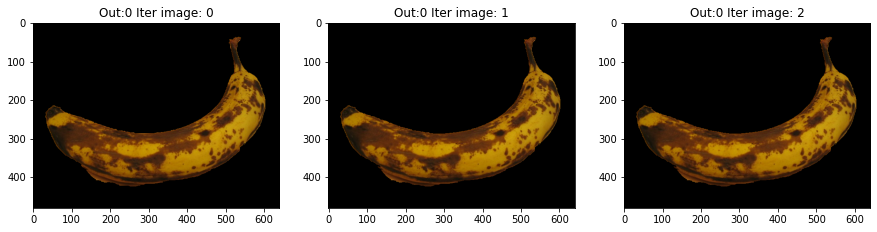

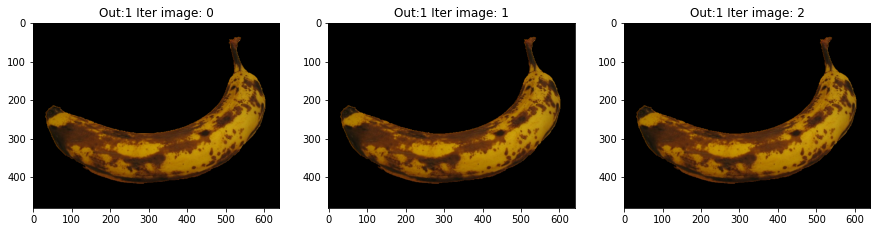

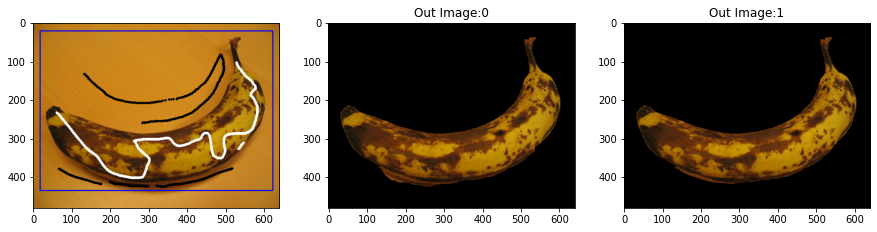

In [13]:
plot_seg_results(banana1_img, banana1_iter_im, banana1_out_im)

## Image : Llama in a desert

In [14]:
filename = '../images/llama.jpg'               # Path to image file
llama_img, llama_iter_im, llama_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (91, 75, 284, 294)
Image shape:  (371, 513, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  753011.1454267444
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  263011.85841127636
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  259706.445405746
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (91, 75, 284, 294)
Image shape:  (371, 513, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  730270.9028344599
Segment

Output images: 2 
Images per run 3




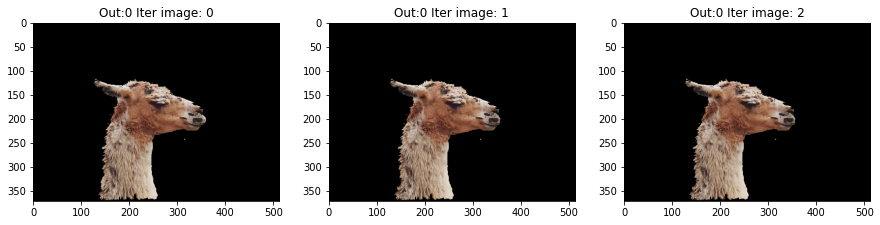

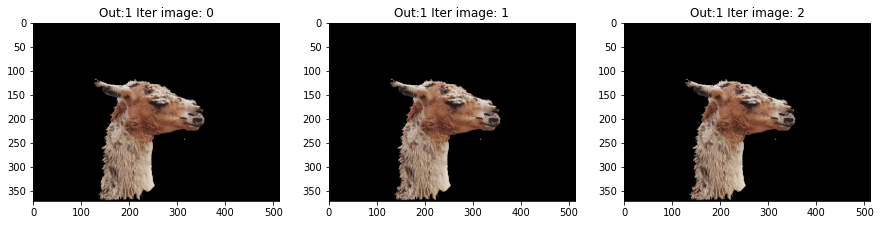

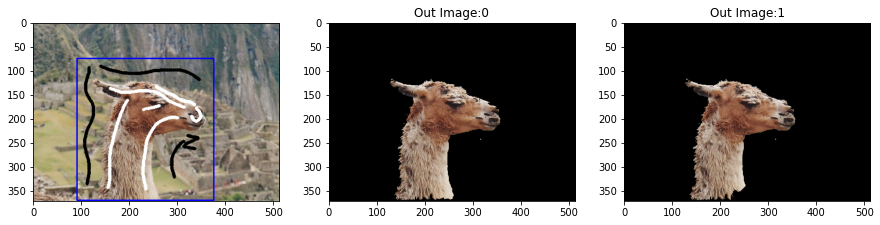

In [15]:
plot_seg_results(llama_img, llama_iter_im, llama_out_im)

Output images: 1 
Images per run 3




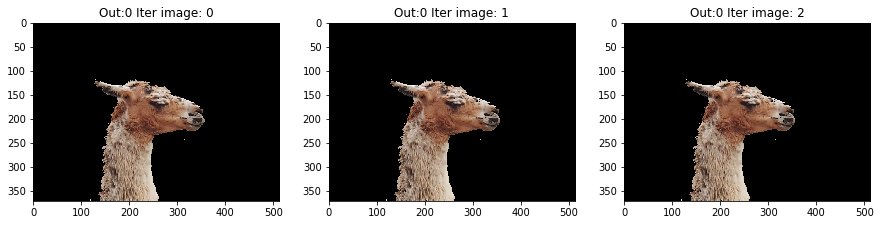

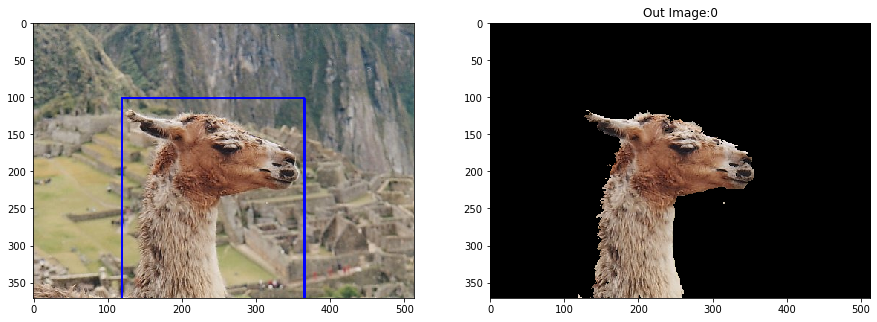

In [25]:
plot_seg_results(llama_img, llama_iter_im, llama_out_im)

## Image : Pink Doll

In [16]:
filename = '../images/doll.jpg'               # Path to image file
doll_img, doll_iter_im, doll_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (14, 21, 411, 449)
Image shape:  (549, 462, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1603955.3614429166
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  971163.0910867085
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  967118.4698580172
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (14, 21, 411, 449)
Image shape:  (549, 462, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1600577.0847497075
Segme

Output images: 2 
Images per run 3




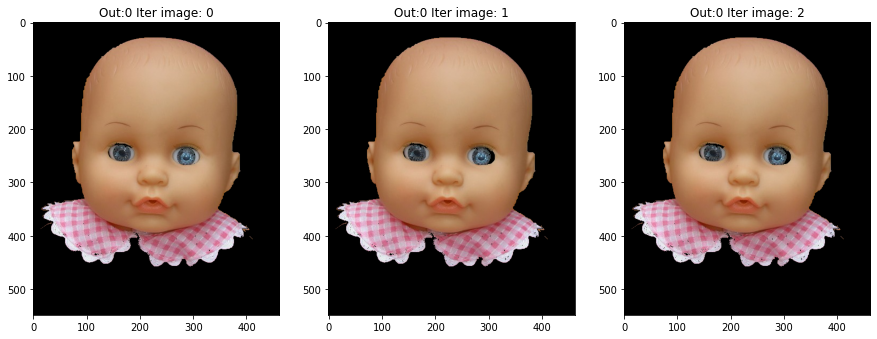

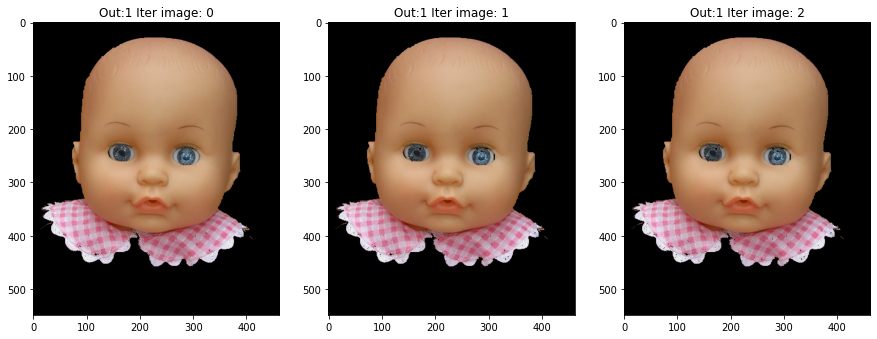

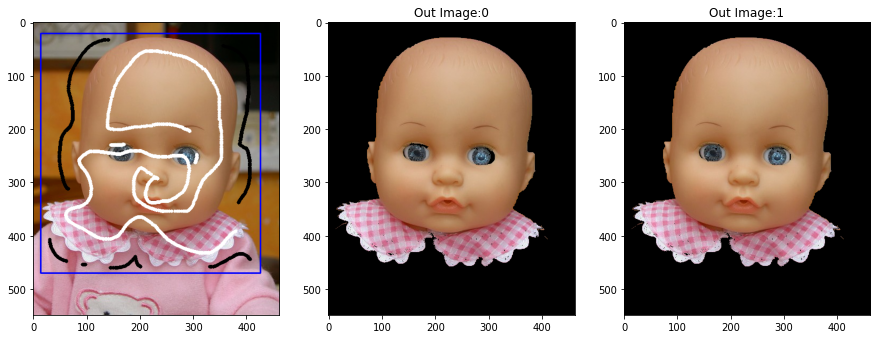

In [17]:
plot_seg_results(doll_img, doll_iter_im, doll_out_im)

## Image : Banana Rose

In [18]:
filename = '../images/banana3.jpg'               # Path to image file
banana3_img, banana3_iter_im, banana3_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (31, 46, 601, 371)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  2267693.82227394
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1067025.8276146578
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  650434.5857145309
Segmentation Done for iter: 2 
*************************************


Iteration---------------->  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  637053.4096272001
Segmentation Done for iter: 3 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Boundin

Output images: 2 
Images per run 4




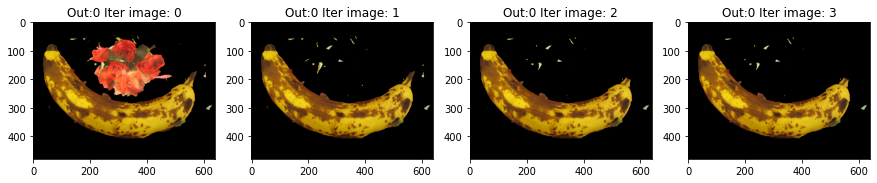

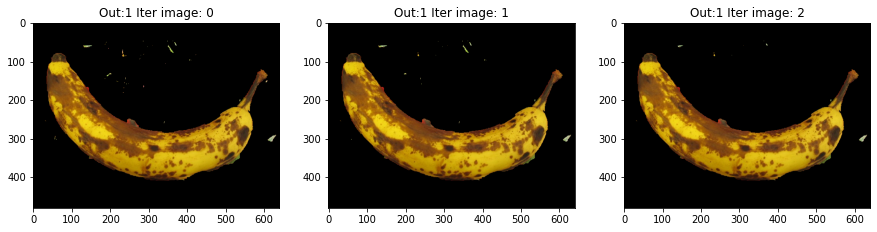

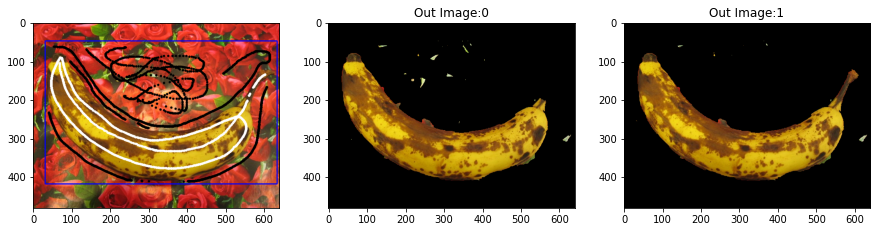

In [19]:
plot_seg_results(banana3_img, banana3_iter_im, banana3_out_im)

## Image : Stone Rock

In [20]:
filename = '../images/stone1.jpg'               # Path to image file
stone1_img, stone1_iter_im, ston1_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (211, 39, 273, 397)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  802195.2108127325
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  446410.7211195608
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  439573.0305942387
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


Output images: 1 
Images per run 3




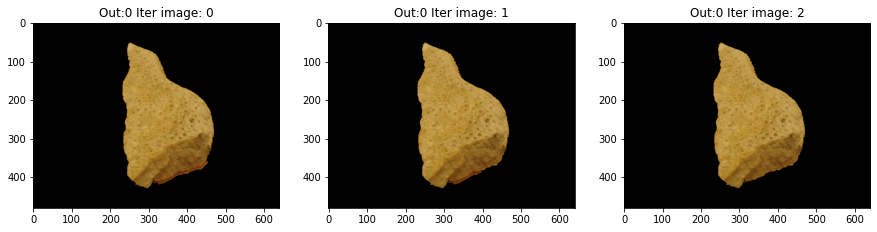

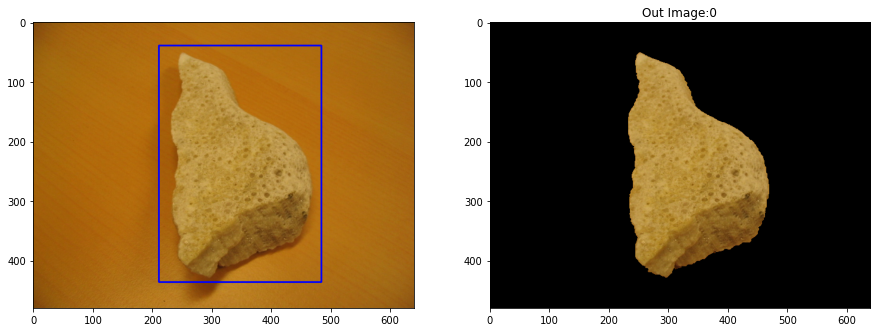

In [21]:
plot_seg_results(stone1_img, stone1_iter_im, ston1_out_im)

## Image : Stone2 Rock

In [26]:
filename = '../images/stone2.jpg'               # Path to image file
stone2_img, stone2_iter_im, stone2_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (185, 8, 329, 434)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1255526.1054165615
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  567029.0701291665
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  568141.8569314572
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


Output images: 1 
Images per run 3




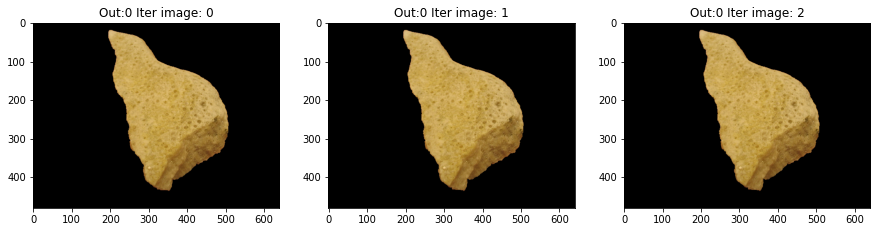

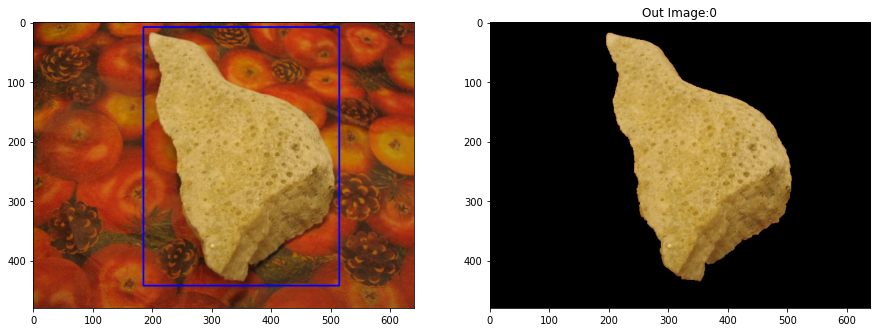

In [27]:
plot_seg_results(stone2_img, stone2_iter_im, stone2_out_im)

## Image : Reading Person

In [22]:
filename = '../images/person6.jpg'               # Path to image file
per6_img, per6_iter_im, per6_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (132, 111, 168, 409)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  601343.18616768
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  302660.39390022476
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  302418.3069184933
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (132, 111, 168, 409)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  588897.4202140811
Segm

Output images: 2 
Images per run 3




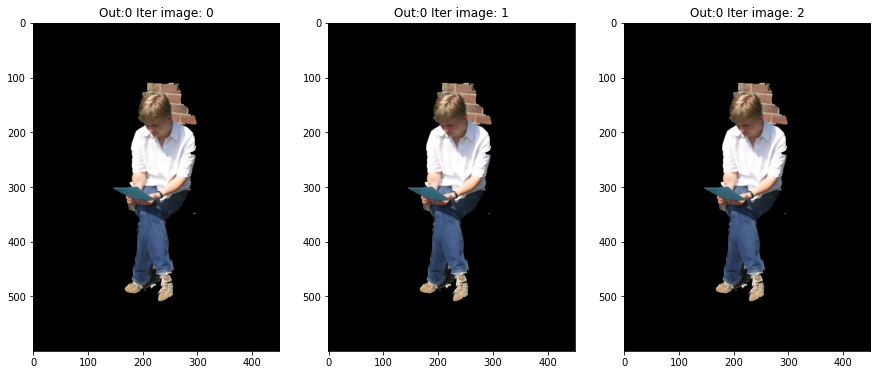

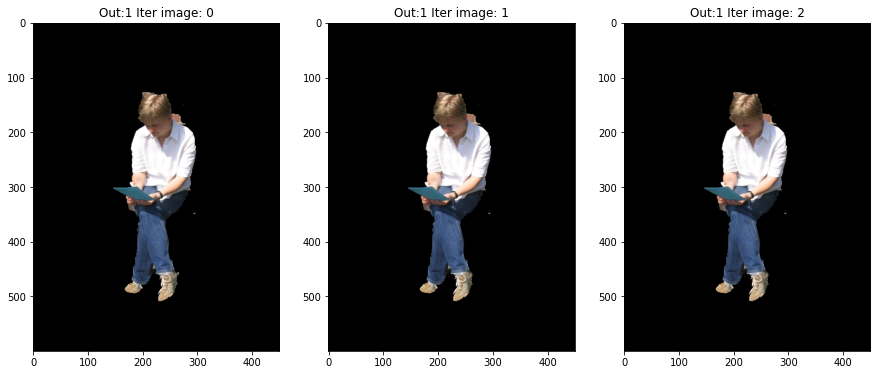

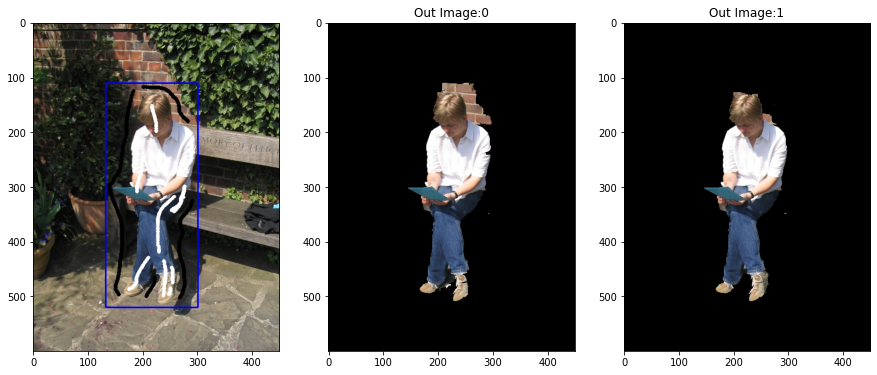

In [23]:
plot_seg_results(per6_img, per6_iter_im, per6_out_im)

## Image : Talking Person

In [28]:
filename = '../images/person5.jpg'               # Path to image file
per5_img, per5_iter_im, per5_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (94, 143, 254, 341)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  723995.6527938228
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  216002.96173863776
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  194214.8692643884
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (94, 143, 254, 341)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  711484.0622710079
Segm

Output images: 3 
Images per run 3




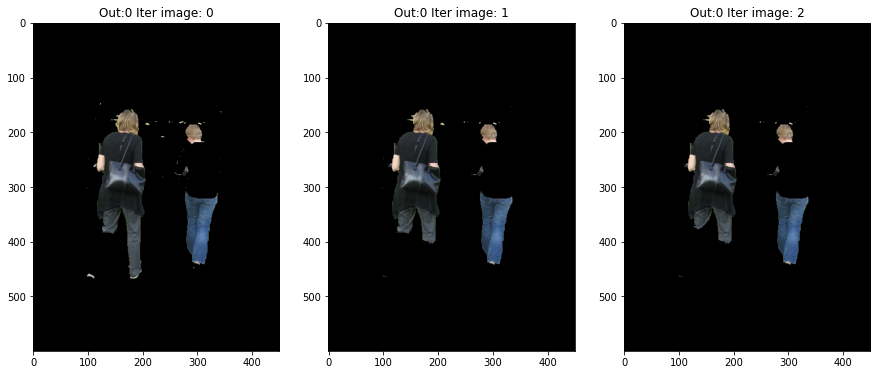

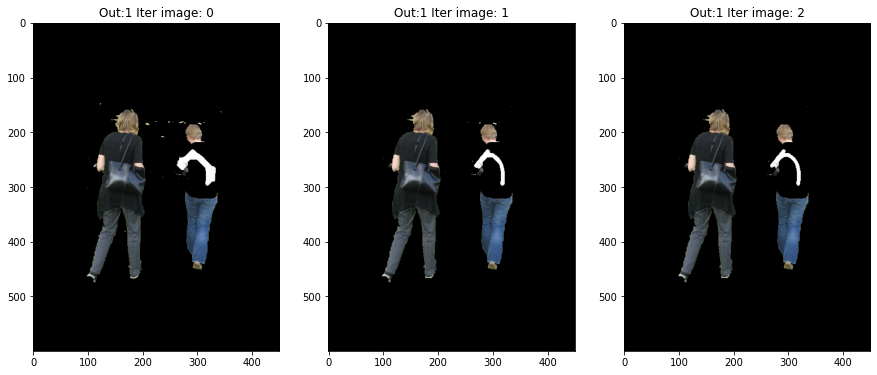

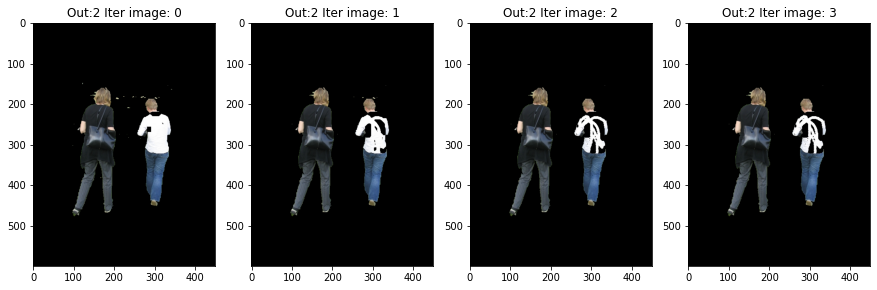

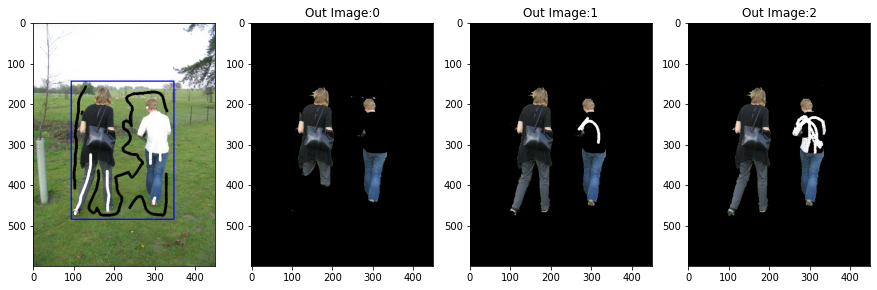

In [29]:
plot_seg_results(per5_img, per5_iter_im, per5_out_im)

## Image : Hiking Person

In [30]:
filename = '../images/person3.jpg'               # Path to image file
per3_img, per3_iter_im, per3_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (151, 206, 177, 362)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  515697.84817433107
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  244162.3862323921
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  223137.25514734304
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bounding Box around: (151, 206, 177, 362)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  511406.0412557403
S

Output images: 2 
Images per run 3




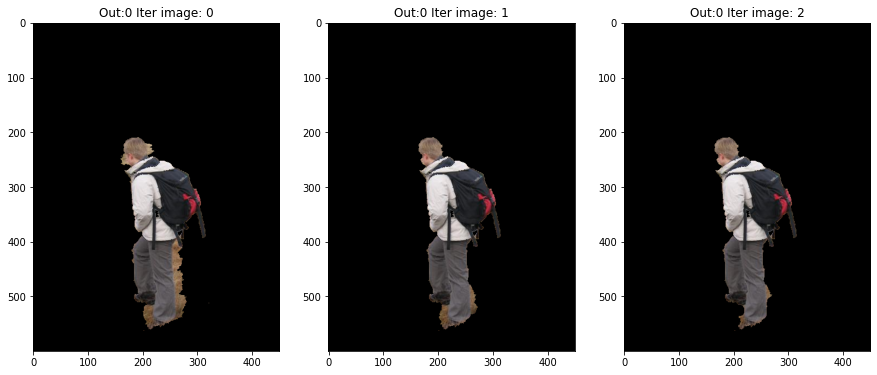

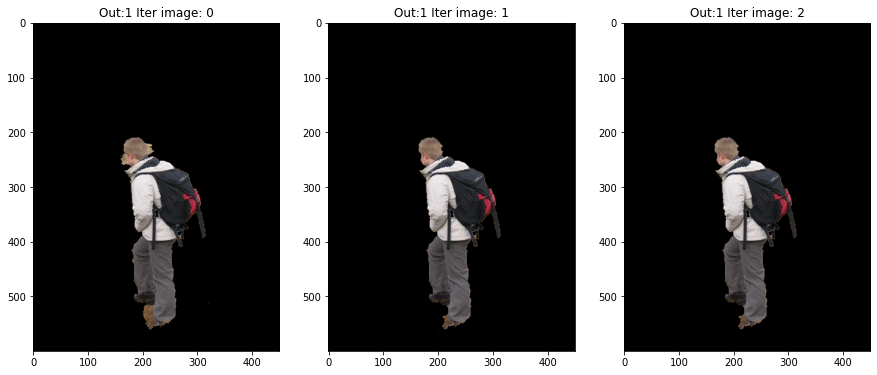

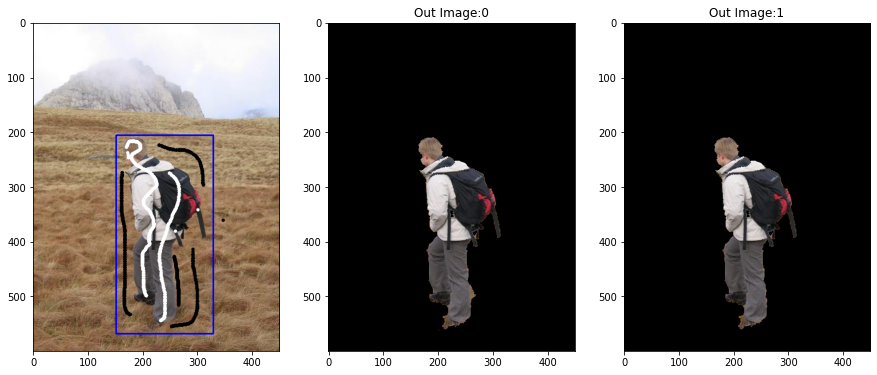

In [31]:
plot_seg_results(per3_img, per3_iter_im, per3_out_im)

## Image: Memorial Shield

In [24]:
filename = '../images/memorial.jpg'               # Path to image file
memorial_im, memorial_iter_im, memorial_out_im = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (57, 144, 293, 355)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  954097.832024056
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  421879.88534810895
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  377759.2169541976
Segmentation Done for iter: 2 
*************************************


Iteration---------------->  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  389088.49678996723
Segmentation Done for iter: 3 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Bound

Output images: 3 
Images per run 4




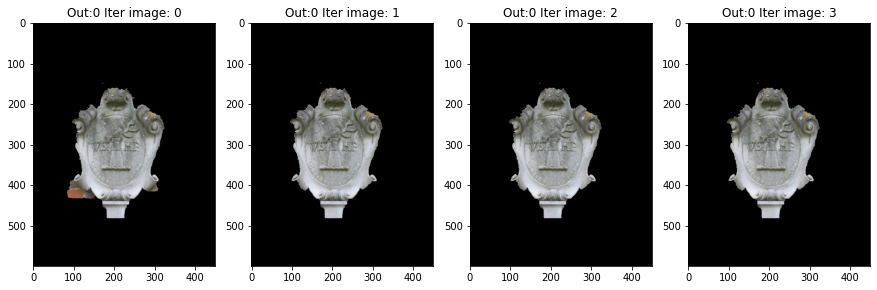

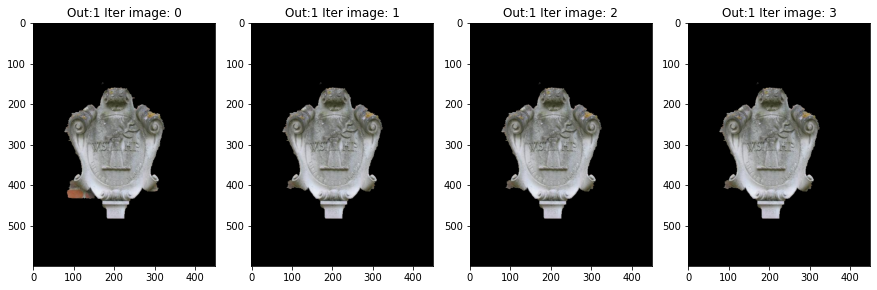

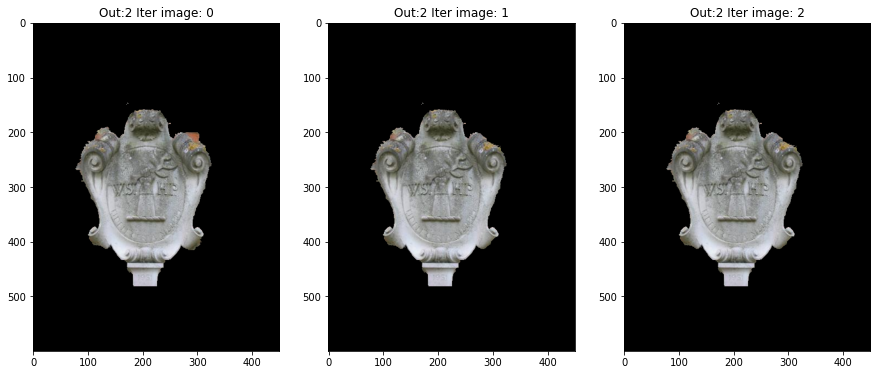

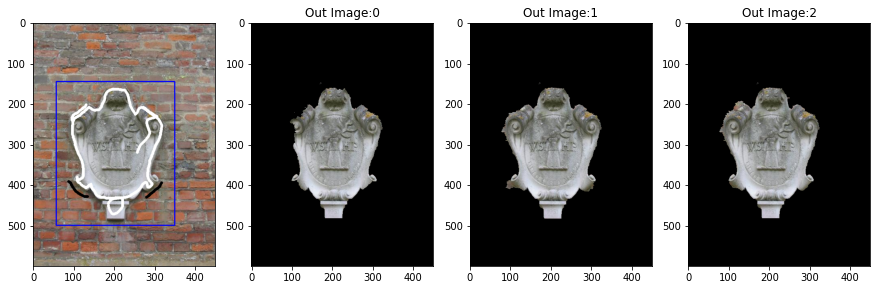

In [25]:
plot_seg_results(memorial_im, memorial_iter_im, memorial_out_im)

## Image: Book

In [32]:
filename = '../images/book.jpg'               # Path to image file
book_im, book_iter_im, book_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (52, 28, 551, 422)
Image shape:  (480, 640, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  2134085.7746070744
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1210693.0399215403
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1156872.781340106
Segmentation Done for iter: 2 
*************************************


Iteration---------------->  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1150397.2358689944
Segmentation Done for iter: 3 
*************************************

mincut converged
Segmentation Done!!!

Implementing Grab Cut ...
Boun

Output images: 3 
Images per run 4




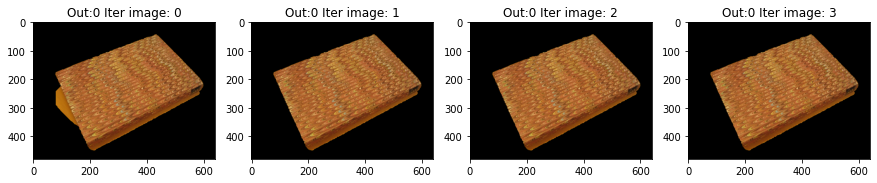

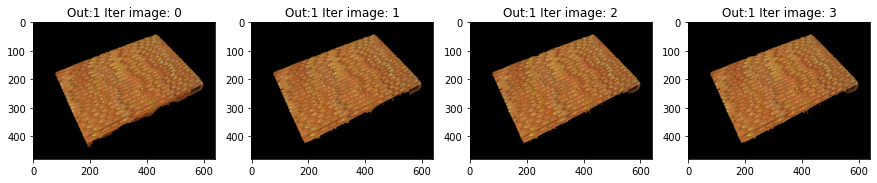

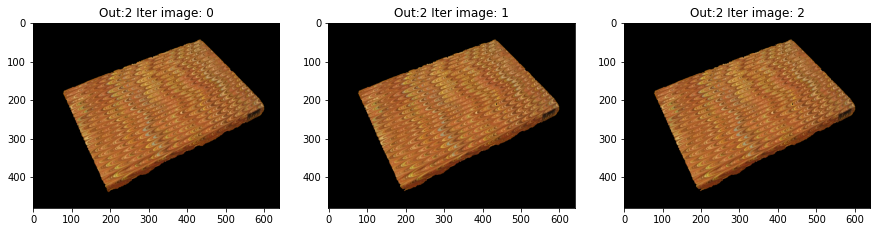

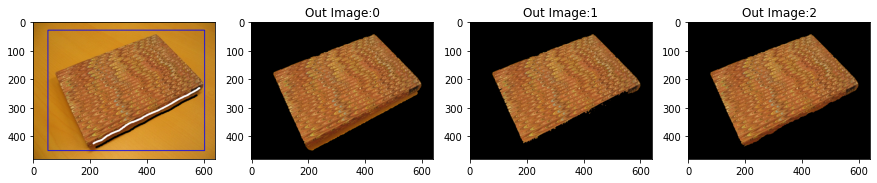

In [33]:
plot_seg_results(book_im, book_iter_im, book_out_im)

## Image: Bool

In [36]:
filename = '../images/bool.jpg'               # Path to image file
bool_im, bool_iter_im, bool_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (40, 46, 456, 399)
Image shape:  (450, 520, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1348544.4594721408
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  425052.6765193486
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  423970.18348282186
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


Output images: 1 
Images per run 3




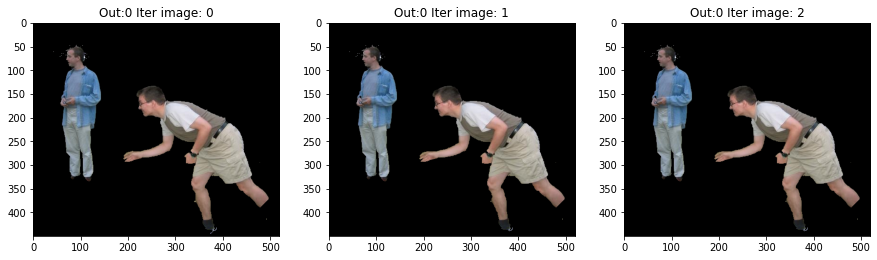

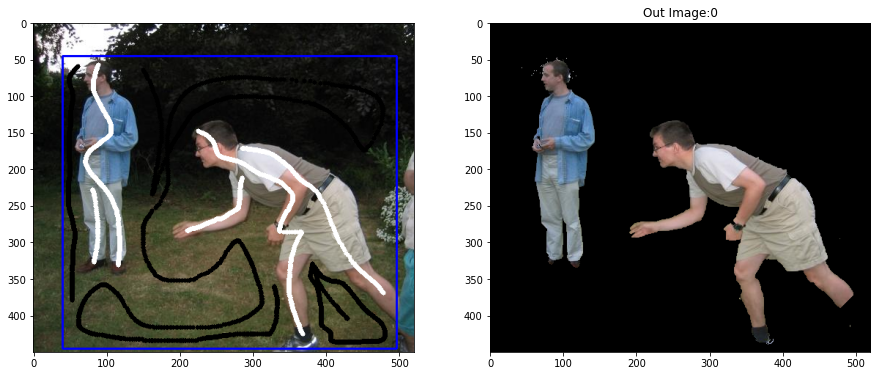

In [37]:
plot_seg_results(bool_im, bool_iter_im, bool_out_im)

## Image: Moon

In [38]:
filename = '../images/fullmoon.jpg'               # Path to image file
moon_im, moon_iter_im, moon_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (143, 105, 132, 133)
Image shape:  (350, 442, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  94113.82267527902
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  107444.55090160223
Segmentation Done for iter: 1 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


Output images: 1 
Images per run 2




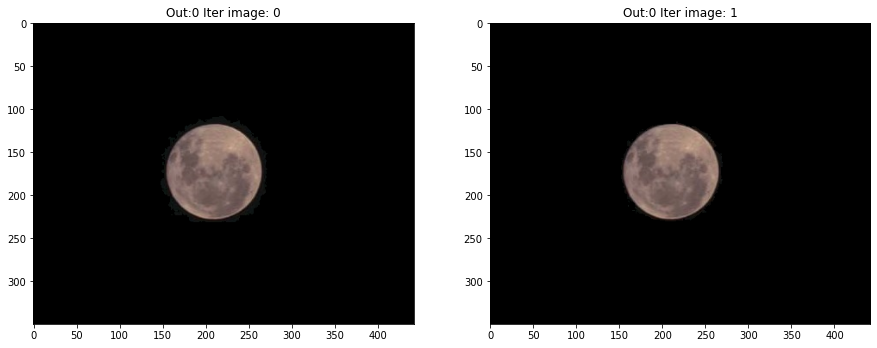

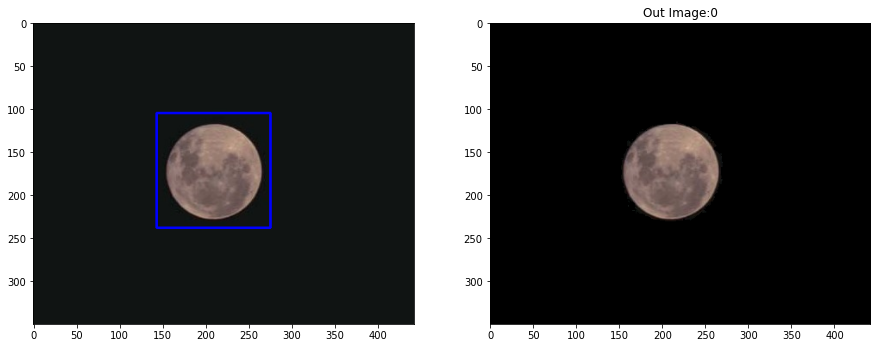

In [39]:
plot_seg_results(moon_im, moon_iter_im, moon_out_im)

## Image: Teddy

In [40]:
filename = '../images/teddy.jpg'               # Path to image file
teddy_im, teddy_iter_im, teddy_out_im = run(filename, 4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (37, 46, 207, 289)
Image shape:  (398, 284, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  445135.33219129633
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  243580.36997100065
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  230342.27884522578
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


Output images: 1 
Images per run 3




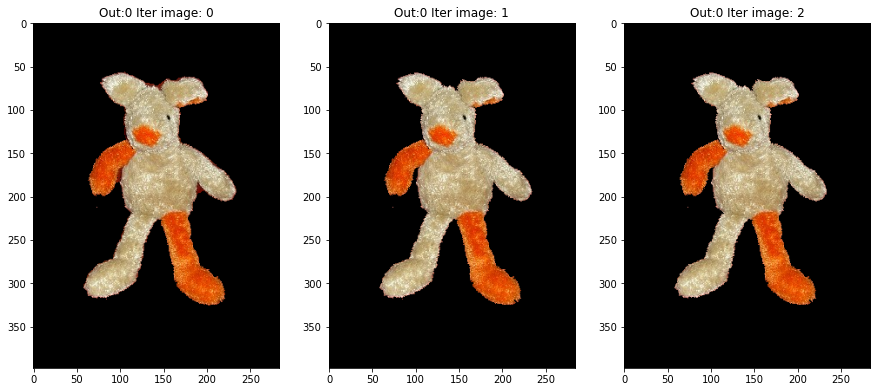

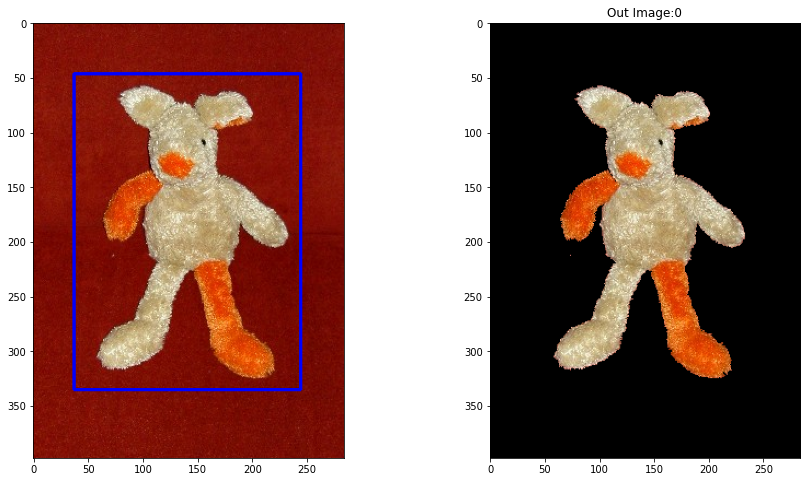

In [41]:
plot_seg_results(teddy_im, teddy_iter_im, teddy_out_im)

# -------------------------------------------------------------------------------------------------------

# Report and Analysis

The following section includes a report about the study of how changes in the various parameters affects the segmentation of an image. These are the hyperparameters that are tuned by experiments and observations. The hyperparameters that explored an explained in this section are as follows : 

1. Number of mixture components in your GMM.

2. Choice of Gamma.

3. Effect of a tight initial bounding box or a loose bounding box.

4. The number of iterations of GMM updating and energy minimization.

5. Neighbourhood Effect: No. of neighbourhoods. (8 or 4 connectivity)

## 1. Analysis of Num GMM Components

The number of GMM components that are specified while initializing the GMM model are indicative of the number of possible colour that are contained within the background and foreground. The model tries to assign the pixels into the *k components* that are used to define the GMM. 

We observe that with *more number of components*, there is a better distribution of pixels into the differnet compoennts, since there exist more number of gaussian distributions that a pixel could probably blong to. Like as we see in the images below, the stem of the bush is not identified as a foreground pixel in the case when *only 2* components are used to define the GMM. 

However, the performance of the GMM for image segmentation does not keep increasing with increase in the number of components. As we see in the second image, a lot of background pixels have been included in the foreground segmentation as well. There exists a middle ground value that is ideal for the segmentation and for modelling the foreground and background pixel distributions. 

__With 2 or 3 Gaussian Mixture Models...__

In [42]:
filename = '../images/bush.jpg'               # Path to image file
bush_im_comp2, bush_iter_im_comp2, bush_out_im_comp2 = run(filename, 5, 2)
cv2.destroyAllWindows()
filename = '../images/cross.jpg'               # Path to image file
cross_im_comp2, cross_iter_im_comp2, cross_out_im_comp2 = run(filename, 5, 3)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (121, 51, 215, 487)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1244397.819979234
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  473368.85916536616
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  463548.9165380702
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing
Implementing Grab Cut ...
Bounding Box around: (127, 16, 178, 578)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  801008.72

Output images: 1 
Images per run 3




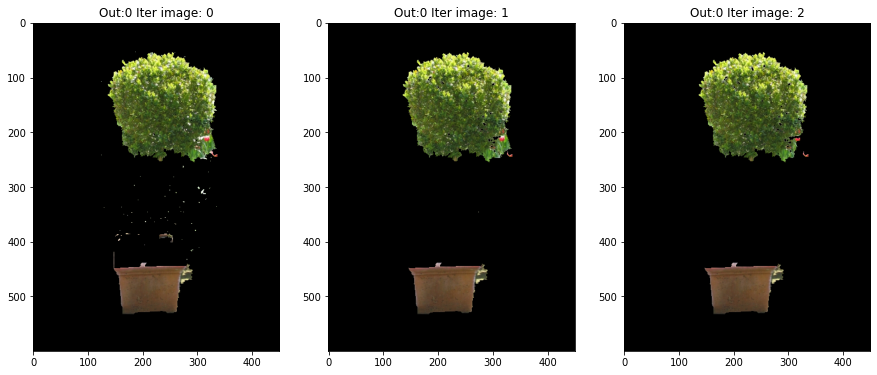

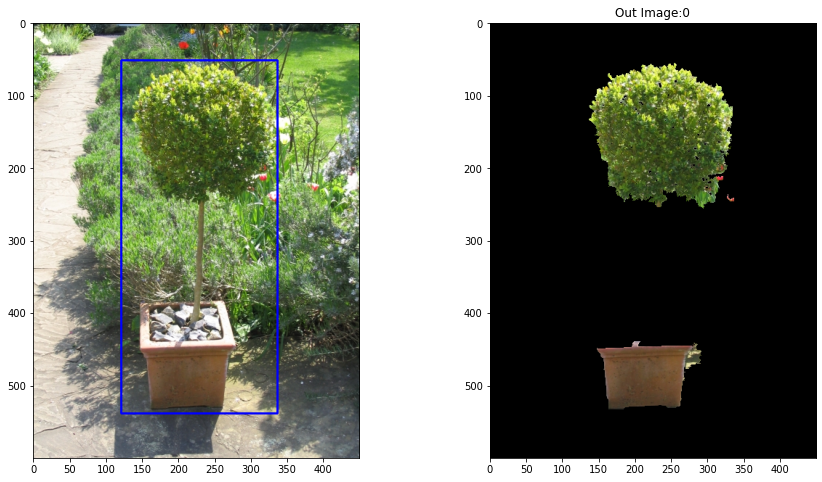

In [43]:
plot_seg_results(bush_im_comp2, bush_iter_im_comp2, bush_out_im_comp2)

Output images: 1 
Images per run 3




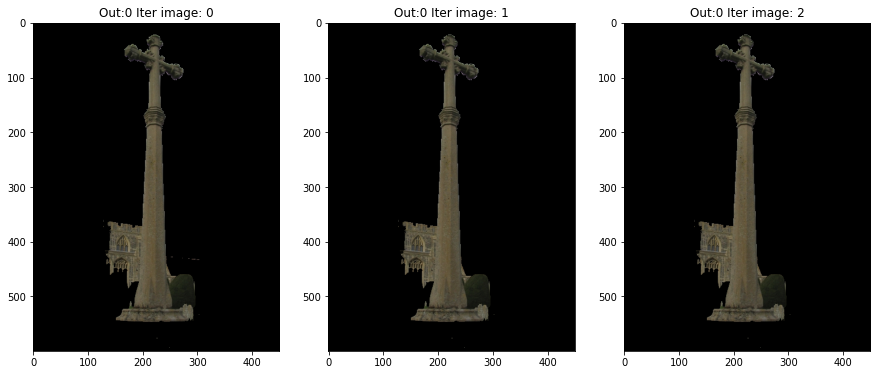

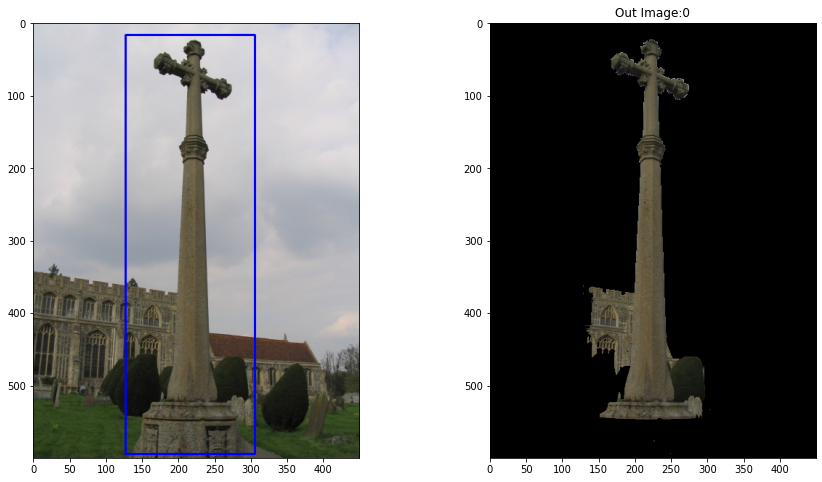

In [44]:
plot_seg_results(cross_im_comp2, cross_iter_im_comp2, cross_out_im_comp2)

__With 10 and 8 Gaussian Mixture Models...__

In [46]:
filename = '../images/bush.jpg'               # Path to image file
bush_im_comp10, bush_iter_im_comp10, bush_out_im_comp10 = run(filename, 5, 10)
cv2.destroyAllWindows()
filename = '../images/cross.jpg'               # Path to image file
cross_im_comp8, cross_iter_im_comp8, cross_out_im_comp8 = run(filename, 5, 8)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (127, 55, 198, 482)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1105162.244642886
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  742572.837467883
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  718501.223781562
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing
Implementing Grab Cut ...
Bounding Box around: (140, 20, 147, 572)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  629651.69235

Output images: 1 
Images per run 3




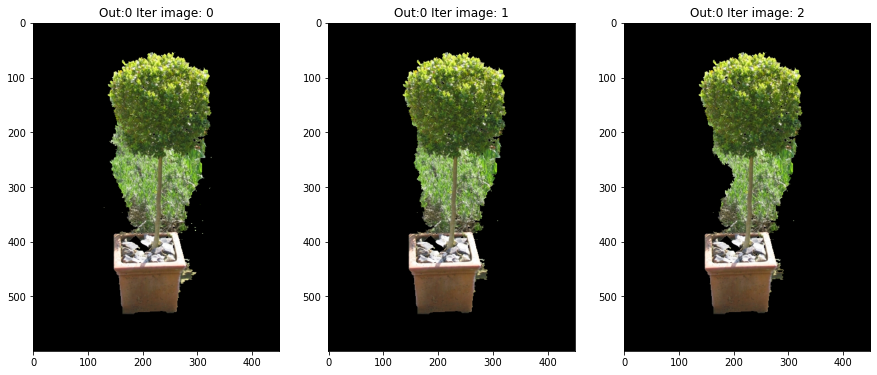

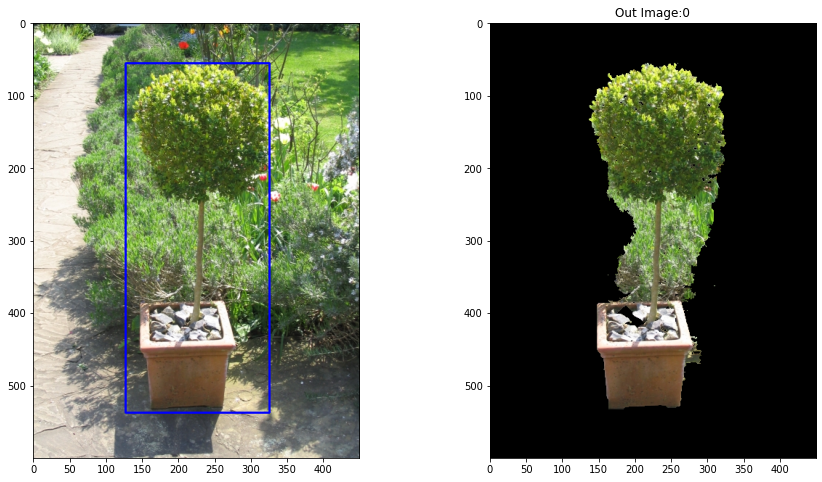

In [47]:
plot_seg_results(bush_im_comp10, bush_iter_im_comp10, bush_out_im_comp10)

Output images: 1 
Images per run 3




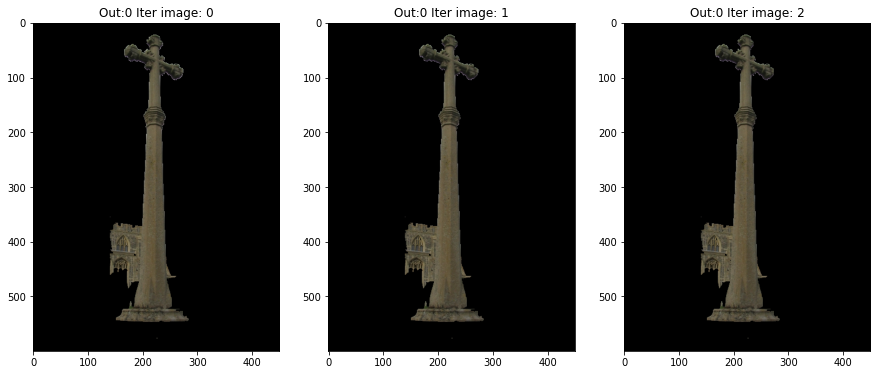

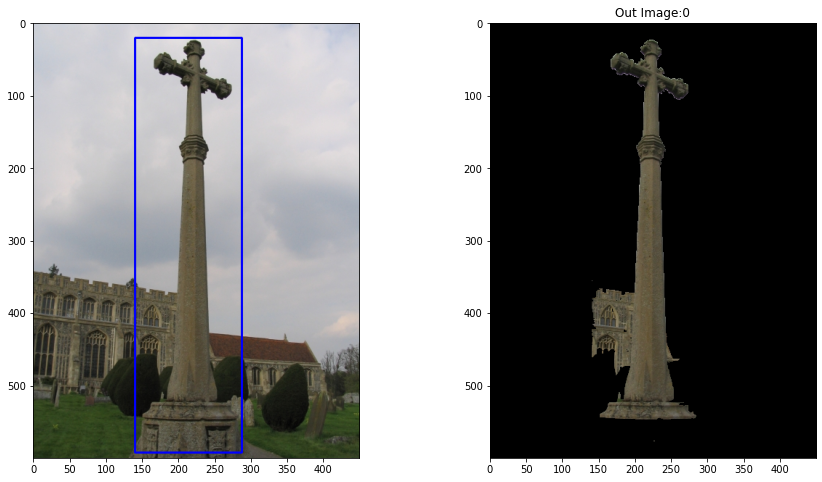

In [49]:
plot_seg_results(cross_im_comp8, cross_iter_im_comp8, cross_out_im_comp8)

__Comaprison__

Text(0.5, 1.0, 'Segmentation with 10 comp')

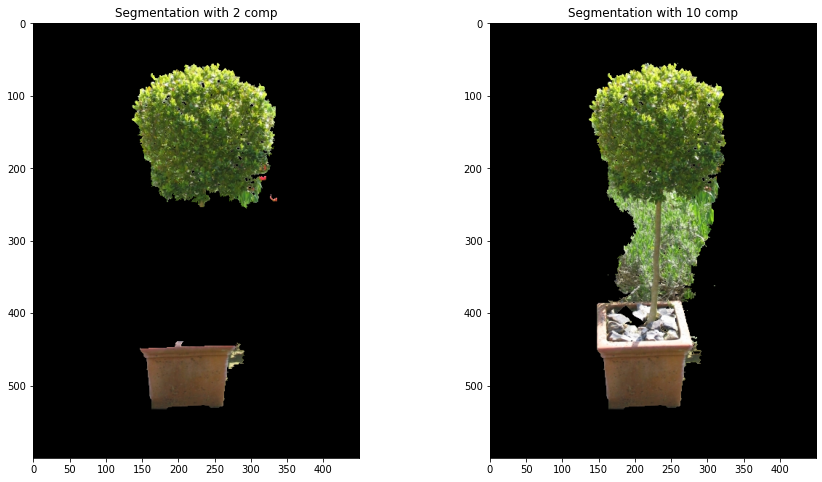

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(bush_out_im_comp2[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("Segmentation with 2 comp")

ax[1].imshow(cv2.cvtColor(bush_out_im_comp10[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with 10 comp")

Text(0.5, 1.0, 'Segmentation with 10 comp')

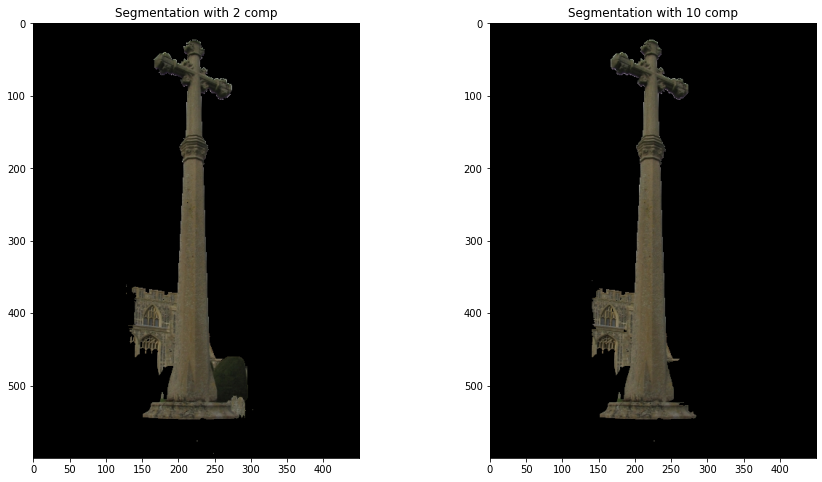

In [51]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(cross_out_im_comp2[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("Segmentation with 2 comp")

ax[1].imshow(cv2.cvtColor(cross_out_im_comp8[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with 10 comp")

__Additional Experiments with Ceramic Image...__

In [48]:
filename = '../images/ceramic.jpg'               # Path to image file
ceramic_im_comp2, ceramic_iter_im_comp2, ceramic_out_im_comp2 = run(filename, 5, 1)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (107, 27, 469, 413)
Image shape:  (480, 640, 3) 

iter =====  0
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1930570.380430695
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1216048.1849406702
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 1
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1206060.2864899384
*************************************
Segmentation Done for iter  2
mincut converged
Segmentation Done!
Grab closing


In [49]:
filename = '../images/ceramic.jpg'               # Path to image file
ceramic_im_comp10, ceramic_iter_im_comp10, ceramic_out_im_comp10 = run(filename, 5, 10)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (100, 28, 460, 407)
Image shape:  (480, 640, 3) 

iter =====  0
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1760130.7983945014
*************************************
Segmentation Done for iter  0
iter =====  1
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1059692.3333584245
*************************************
Segmentation Done for iter  1
iter =====  2
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1019001.130318911
*************************************
Segmentation Done for iter  2
iter =====  3
self.comp 10
Building segmentation graph ...
Graph prepared, starting segmentation ...
Mincut cost =  1009551.276442795
*************************************
Segmentation Done for iter  3
mincut converged
Segmentation Done!
Grab closing


Text(0.5, 1.0, 'Segmentation with 10 comp')

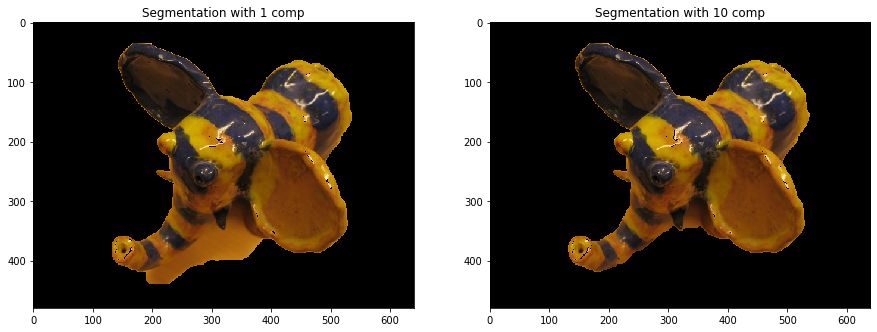

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(cv2.cvtColor(ceramic_out_im_comp2[0], cv2.COLOR_BGR2RGB))
ax[0].set_title("Segmentation with 1 comp")

ax[1].imshow(cv2.cvtColor(ceramic_out_im_comp10[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with 10 comp")

## 2. Analysis of Gamma 

The $\gamma$ parameter that is a part of the smoothness term in the Gibbs energy equation decides the degree to which the image is smoothened. This smoothness is required between regions of low contrast and high contrast, since generally images have nature of being continuous and hence there must be a gradual transition in portions of the image that are not edges. The following images show the effect of tweaking this hyperparameter $\gamma$

In [52]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma1, person3_iter_im_gamma1, person3_out_im_gamma1 = run(filename, 5, 5, 1)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (151, 207, 168, 358)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  516255.01850294217
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  350258.9252300781
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  270437.49568791146
Segmentation Done for iter: 2 
*************************************


Iteration---------------->  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  227324.509689353
Segmentation Done for iter: 3 
*************************************


Iteration---------------->  4
Building segmentation graph ...
Graph 

In [53]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma50, person3_iter_im_gamma50, person3_out_im_gamma50 = run(filename, 5, 5, 50)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (154, 206, 164, 361)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  542526.004996108
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  287724.23932609265
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  256030.17931434058
Segmentation Done for iter: 2 
*************************************


Iteration---------------->  3
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  248700.4982413281
Segmentation Done for iter: 3 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


In [54]:
filename = '../images/person3.jpg'               # Path to image file
person3_im_gamma250, person3_iter_im_gamma250, person3_out_im_gamma250 = run(filename, 5, 5, 250)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (153, 201, 167, 363)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  645059.0106037079
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  289509.3061953046
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  282370.9636667482
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


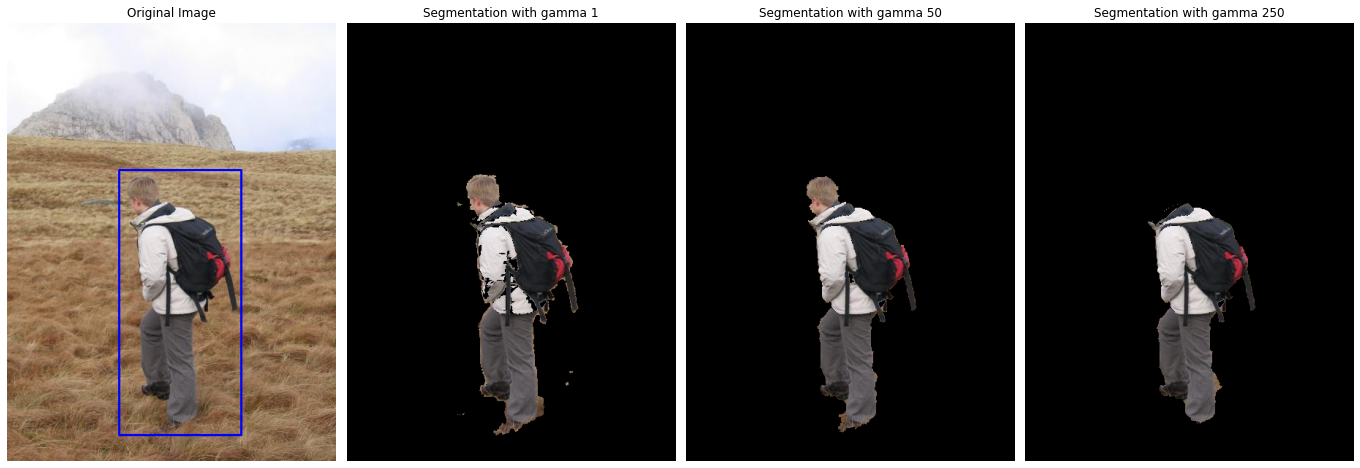

In [55]:
fig, ax = plt.subplots(1,4,figsize=(20,15))
ax[0].imshow(cv2.cvtColor(person3_im_gamma250, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(person3_out_im_gamma1[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with gamma 1")
ax[1].set_axis_off()

ax[2].imshow(cv2.cvtColor(person3_out_im_gamma50[0], cv2.COLOR_BGR2RGB))
ax[2].set_title("Segmentation with gamma 50")
ax[2].set_axis_off()

ax[3].imshow(cv2.cvtColor(person3_out_im_gamma250[0], cv2.COLOR_BGR2RGB))
ax[3].set_title("Segmentation with gamma 250")
ax[3].set_axis_off()

fig.tight_layout(rect=[0,0,0.95,1])
plt.show()

### Observations 

As we see that the value of $\gamma$ plays a critical role in assigning the interpixel weights to the edges in the graph of pixels. For a **very low** value of $\gamma$, the segmentation leaves in some of the pixels that do not belong to the foreground. As we can see some of the grass still remains in the image. While a **very high** value of $\gamma$ causes some of the foreground itself to get removed, since in the case that the foreground and background pixels are of same colour and intensity, a high $\gamma$ implies a higher edge cost. Therefore we see that the trekkers head is erased with a very high $\gamma$. 

An ideal middle-ground value of $\gamma$ should be chosen, as suggested by the paper. A value of 50 gives the most promising result for this segmentation.

## 3. Bounding Box 

The novelty proposed in the grabcut implementation lies in the convenient and minimalistic UI that it proposes for image segmentation. The bounding box is to be drawn around the foreground region that is to be segmented out. Two factors of the bounding box are analysed below namely a) fit of the box, b) improvements to box for segmentation

__Take a Loose BB on Grave Image...__

In [56]:
filename = '../images/grave.jpg'               # Path to image file
grave_im_loose, grave_iter_im_loose, grave_out_im_loose = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (48, 36, 385, 517)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1740980.2980223452
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  600830.8111882103
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  589953.148126097
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


__Take a Tight BB on Grave Image...__

In [57]:
filename = '../images/grave.jpg'               # Path to image file
grave_im_tight, grave_iter_im_tight, grave_out_im_tight = run(filename, 5)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (170, 156, 161, 296)
Image shape:  (600, 450, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  425073.1573175288
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  284982.4244785148
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  267720.1735204581
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing


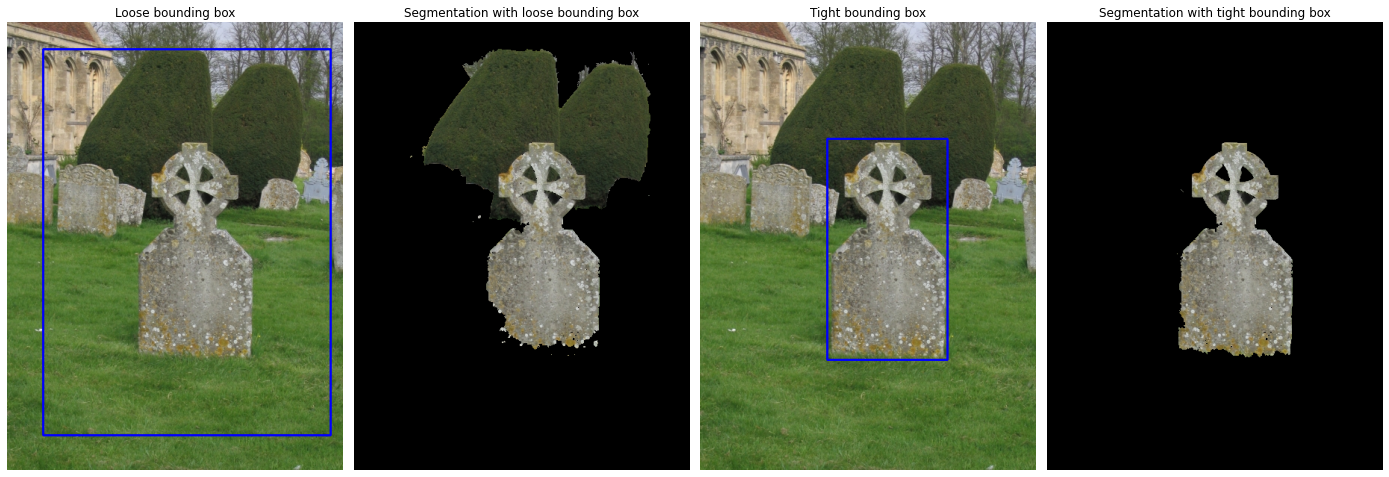

In [58]:
fig, ax = plt.subplots(1,4,figsize=(20,15))
ax[0].imshow(cv2.cvtColor(grave_im_loose, cv2.COLOR_BGR2RGB))
ax[0].set_title("Loose bounding box")
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(grave_out_im_loose[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with loose bounding box")
ax[1].set_axis_off()

ax[2].imshow(cv2.cvtColor(grave_im_tight, cv2.COLOR_BGR2RGB))
ax[2].set_title("Tight bounding box")
ax[2].set_axis_off()

ax[3].imshow(cv2.cvtColor(grave_out_im_tight[0], cv2.COLOR_BGR2RGB))
ax[3].set_title("Segmentation with tight bounding box")
ax[3].set_axis_off()
fig.tight_layout(rect=[0,0,0.97,1])
plt.show()

### Observations

a) Starting off with a loose or a tight initial bounding box can affect the segmentation of the image. This is because a looser bounding box would mean, more amound of background pixels are incorporated into the $T_U$ region and hence the GMM model will be trained on a lot of bg pixels as well. This may result in bad segmentation results. While a tighter bounding box ensures that the foreground GMM model is as close to the distribution of colours in the foreground pixels and that the GMM models the foreground pixels as accurately as possible. 

b) Further, a few proposals to use bounding boxes for segmentation can be to incorporate flexible shapes for the bounding box. That is the user can specify the bounding box coordinates via the UI and the figure need not be a concave polygon in this case. This can ensure that the box is a tighter fit on the foreground object. Another option could be to integrate the magic wand tool for this GMM based grab cut segmentation. This will inturn provide an even tighter bound to the foreground pixels.

## 4. Iterations of GMM update and Energy minimization

With increased iterations of GMM update and energy minimization, the segmentation gets better and better. As we observe in the llama image, the segmentation gets better from the 1st to the 2nd image by omitting some of the background pixels. 

This is because, with each iteration, the $\alpha$ values are assigned to each pixel, marking them as either fg or bg, and in every iteration the GMM model for the fg and bg is learnt for the fg and bg pixels for that iteration. As a result, the models in successive iterations will learn GMMs that have more specific fg pixels than bg pixels and hence result in better segmentation.

However, once again, this isn't a monotonically increasing function as at some point the algorithm converges. This convergence is achieved either when the difference in the mincut values between two successive iterations is < a THRESH or this algorithm is found to empirically converge after around 5-6 iterations.

In [62]:
filename = '../images/person1.jpg'               # Path to image file

person1_im, person1_iter_im, person1_out_im = run(filename, 2, thresh=10000)
cv2.destroyAllWindows()

person1_im5, person1_iter_im5, person1_out_im5 = run(filename, 5, thresh=10000)
cv2.destroyAllWindows()

person1_im10, person1_iter_im10, person1_out_im10 = run(filename, 10, thresh=10000)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (39, 50, 559, 396)
Image shape:  (450, 600, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  2275829.6933320947
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  623035.3130719813
Segmentation Done for iter: 1 
*************************************

Segmentation Done!!!

Grab closing
Implementing Grab Cut ...
Bounding Box around: (39, 50, 558, 397)
Image shape:  (450, 600, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  2278220.5039047077
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  622266.7350821802
Segmentat

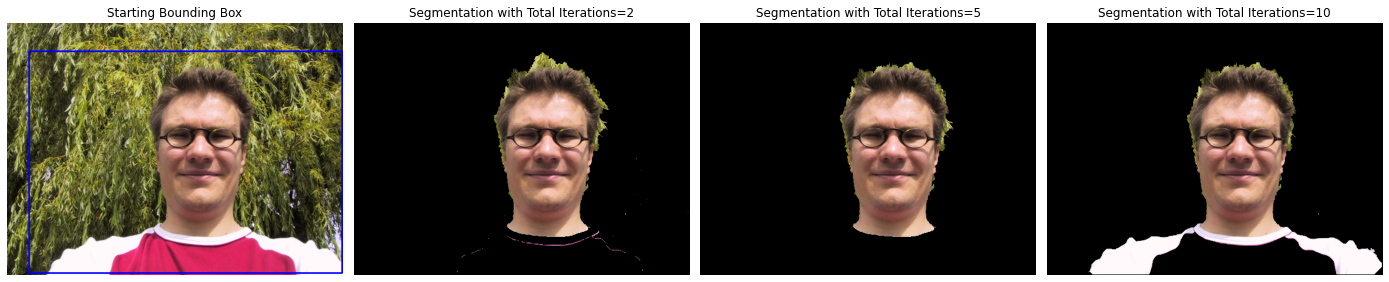

In [64]:
fig, ax = plt.subplots(1,4,figsize=(20,15))
ax[0].imshow(cv2.cvtColor(person1_im, cv2.COLOR_BGR2RGB))
ax[0].set_title("Starting Bounding Box")
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(person1_out_im[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with Total Iterations=2")
ax[1].set_axis_off()

ax[2].imshow(cv2.cvtColor(person1_out_im5[0], cv2.COLOR_BGR2RGB))
ax[2].set_title("Segmentation with Total Iterations=5")
ax[2].set_axis_off()

ax[3].imshow(cv2.cvtColor(person1_out_im10[0], cv2.COLOR_BGR2RGB))
ax[3].set_title("Segmentation with Total Iterations=10")
ax[3].set_axis_off()
fig.tight_layout(rect=[0,0,0.97,1])
plt.show()

## 5. Effect of Connectivity (8-Connectivty v/s 4-connectivity) :

How the diagonal configurations affect the algoritms and what output we get at the end only matters to us. With a diamond neighborhood, diagonal "in" elements will not be connected. With the square neighborhood they will.

In [65]:
filename = '../images/flower.jpg'               # Path to image file

flower_im8, flower_iter_im8, flower_out_im8 = run(filename, 5, grab_conn=8)
cv2.destroyAllWindows()

flower_im4, flower_iter_im4, flower_out_im4 = run(filename, 5, grab_conn=4)
cv2.destroyAllWindows()

Implementing Grab Cut ...
Bounding Box around: (145, 70, 314, 328)
Image shape:  (450, 600, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1126843.1019699872
Segmentation Done for iter: 0 
*************************************


Iteration---------------->  1
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  617733.3584351203
Segmentation Done for iter: 1 
*************************************


Iteration---------------->  2
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  615927.810343947
Segmentation Done for iter: 2 
*************************************

mincut converged
Segmentation Done!!!

Grab closing
Implementing Grab Cut ...
Bounding Box around: (137, 72, 323, 319)
Image shape:  (450, 600, 3) 


Iteration---------------->  0
Building segmentation graph ...
Graph prepared, starting segmentation ...
MinCut cost =  1125944.81

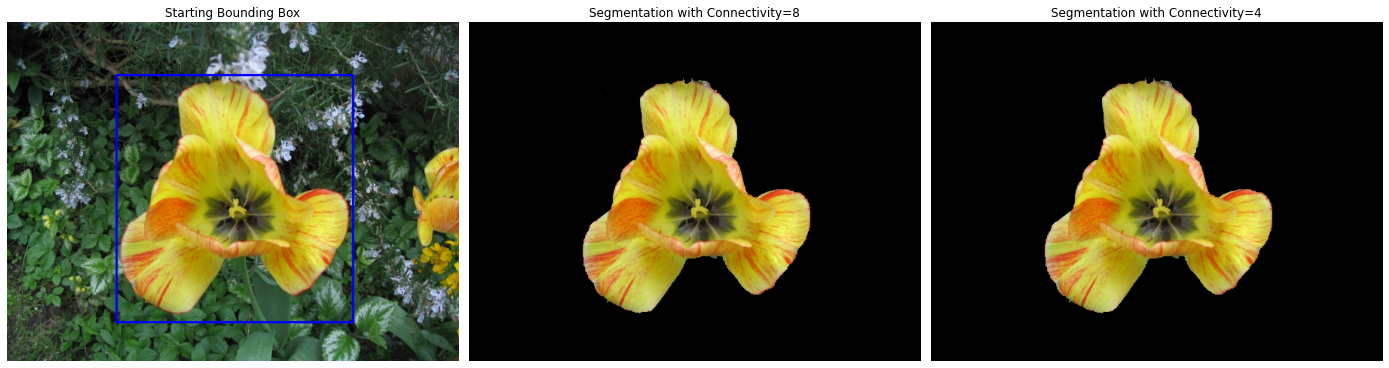

In [67]:
fig, ax = plt.subplots(1,3,figsize=(20,15))
ax[0].imshow(cv2.cvtColor(flower_im8, cv2.COLOR_BGR2RGB))
ax[0].set_title("Starting Bounding Box")
ax[0].set_axis_off()

ax[1].imshow(cv2.cvtColor(flower_out_im8[0], cv2.COLOR_BGR2RGB))
ax[1].set_title("Segmentation with Connectivity=8")
ax[1].set_axis_off()

ax[2].imshow(cv2.cvtColor(flower_out_im4[0], cv2.COLOR_BGR2RGB))
ax[2].set_title("Segmentation with Connectivity=4")
ax[2].set_axis_off()
fig.tight_layout(rect=[0,0,0.97,1])
plt.show()

# ROUGH